<a href="https://colab.research.google.com/github/mustafaerdikararmaz/BICE/blob/main/bice_week6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 6: Plasticity
## WANTED: Third Factor
We have made time our (dimensional) ally and biology an acquaintance. To truly win over the latter, Alcuin of York (735-804, computational neuroscientist) suggests a show of good faith. On top of biological neuron models, we shall look at how we learn - away from backpropagation, towards biological plausibility! Surely this will not cost us any performance.

## STDP for thee (6 points)
One popular experiment to visualise the effects of STDP is latency reduction as described in [(Song et al., 2000)](https://www.nature.com/articles/nn0900_919). We will setup a network of several input neurons and a single output, then record spike activity on the post-synaptic one before and after the plasticity phase as well as weight distribution.

We won't actually simulate the pre-synaptic neurons; instead we'll generate their spike times in bursts offset by a relative latency to fixed event times. We then feed those pre-generated spike times into the post-synaptic LIF neuron and update the weights for every connection.


In the absence of spikes, pre and post synaptic traces decay exponentially:

$$
\begin{align*}
  \tau_{+}\dot{\alpha_{pre}} = -\alpha_{pre} \\
   \tau_{-}\dot{\alpha_{post}} = -\alpha_{post}
\end{align*}
$$

When a pre-synaptic spike arrives:
$$
\begin{align*}
  \alpha_{pre} = \alpha_{pre} + A_{+} \\
   w = w + \alpha_{post}
\end{align*}
$$

conversely, when a post-synaptic spike arrives:
$$
\begin{align*}
  \alpha_{post} = \alpha_{post} + A_{-} \\
   w = w + \alpha_{pre}
\end{align*}
$$



Below is the basic LIF scaffolding and frequency event generation code.


**Exercise 1.1** Fill out the `TODO`s!

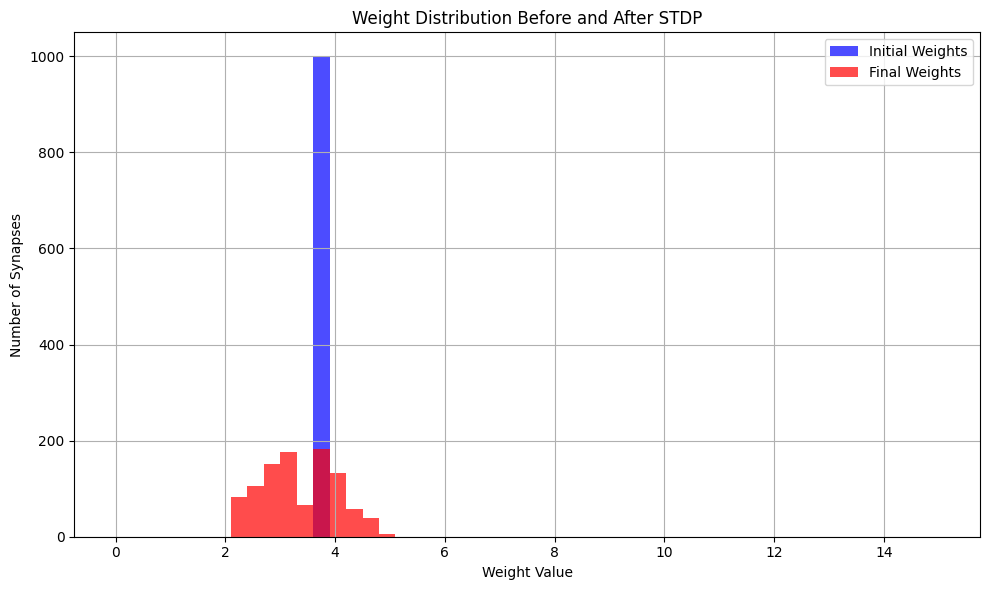

In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Basic LIF
tau_m = 10.0  # Membrane time constant (ms)
R_m = 1.0  # Resistance (MΩ)
V_reset = -75.0  # Reset potential (mV)
V_th_base = -55.0  # Spike threshold (mV)
V_rest = -70.0  # Resting potential (mV)
t_ref = 2  # Refractory period (ms)

# Network
num_neurons_pre = 1000
num_neurons_post = 1

# STDP Params
tau_plus = 20.0  # Pre-synaptic trace decay const (ms)
tau_minus = 5.0  # Post-synaptic trace decay const (ms)
A_plus = 0.2  # LTP learning rate
A_minus = -0.2  # LTD learning rate (both large values to clearly show the effect)
pre_inc = 5.0  # Increment for pre-synaptic trace
post_inc = 5.0  # Increment for post-synaptic trace
w_max = 15.0 # Maximum weight
w_min = 0.0 # Minimum weight


def dVm_dt(V, I_syn):
    return (-(V - V_rest) + R_m * I_syn) / tau_m


def relative_freq_spike_times(sim_time, dt, intra_burst_rate, burst_duration):
    event_interval = 250  # arbitrary interval
    event_times = np.arange(event_interval, sim_time, event_interval)
    relative_latencies = np.random.normal(loc=0, scale=15, size=num_neurons_pre)  # ms

    intra_burst_period_ms = (1 / intra_burst_rate) * 1000
    intra_burst_period_steps = int(np.round(intra_burst_period_ms / dt))
    burst_duration_steps = int(burst_duration / dt)
    spike_trains = np.zeros((num_neurons_pre, num_steps))

    for event_time_ms in event_times:
        for neuron_idx in range(num_neurons_pre):
            burst_start_time = event_time_ms + relative_latencies[neuron_idx]
            if burst_start_time < 0 or burst_start_time >= sim_time:
                continue
            burst_start_step = int(np.round(burst_start_time / dt))
            burst_end_step = min(burst_start_step + burst_duration_steps, num_steps)
            actual_spike_times_in_burst = np.arange(burst_start_step, burst_end_step, intra_burst_period_steps)
            valid_spike_indices = actual_spike_times_in_burst[actual_spike_times_in_burst < num_steps].astype(int)
            spike_trains[neuron_idx, valid_spike_indices] = 1

    return spike_trains


def simulate_lif(sim_time, dt, spike_trains):
    steps = int(sim_time / dt)

    V_m = V_rest
    refrac_counter = 0

    # Store traces for later plotting
    Vm_trace = np.zeros(steps)
    Vm_trace[0] = V_m

    trace_post = np.zeros(num_neurons_post)  # we only have a single neuron here; you can use trace_post[0] to access it
    trace_pre = np.zeros(num_neurons_pre)

    initial_weights = np.ones(num_neurons_pre) * (0.25 * w_max)  # static initialisation for all weights
    weights = np.copy(initial_weights)

    # --- Simulation Loop (Forward Euler Method) ---
    for i in range(1, steps):
        current_Vm = Vm_trace[i - 1]

        spiked_pre = np.where(spike_trains[:, i] == 1)[0]  # all neuron ids that spiked this time step
        current_I_syn = np.sum(weights[spiked_pre])  # combined weights of all incoming spikes for current step

        # TODO: Exponential decay for traces
        trace_pre = trace_pre * np.exp(-dt / tau_plus)
        trace_post = trace_post * np.exp(-dt / tau_minus)

        # TODO: STDP update


        # TODO: Implement pre-synaptic trace + weights update
        for pre_id in spiked_pre:
            trace_pre[pre_id] += pre_inc
            weights[pre_id] += A_plus * trace_post[0]

        weights = np.clip(weights, w_min, w_max)




        dVm = dVm_dt(current_Vm, current_I_syn)  # no background current this time; only synaptic input

        updated_Vm = current_Vm
        if refrac_counter == 0:
            updated_Vm = current_Vm + dVm * dt
        else:
            refrac_counter -= 1

        if updated_Vm >= V_th_base:
            updated_Vm = V_reset
            refrac_counter = int(t_ref / dt)

            # TODO: Implement post-synaptic trace + weights update
            trace_post[0] += post_inc
            weights += A_minus * trace_pre
            weights = np.clip(weights, w_min, w_max)


        Vm_trace[i] = updated_Vm

    return Vm_trace, initial_weights, weights


def plot_weight_dist(initial_weights, final_weights):
    plt.figure(figsize=(10, 6))

    plt.hist(initial_weights, bins=50, alpha=0.7, label='Initial Weights', color='blue', range=(w_min, w_max))
    plt.hist(final_weights, bins=50, alpha=0.7, label='Final Weights', color='red', range=(w_min, w_max))

    plt.xlabel("Weight Value")
    plt.ylabel("Number of Synapses")
    plt.title("Weight Distribution Before and After STDP")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    sim_duration = 10000.0  # Total simulation time (ms)
    time_step = 0.1  # Time step (ms)
    num_steps = int(sim_duration / time_step)

    # Run & plot
    spike_trains = relative_freq_spike_times(sim_duration, time_step, intra_burst_rate=100, burst_duration=20)
    voltage_trace, initial_weights, final_weights = simulate_lif(sim_duration, time_step, spike_trains)
    plot_weight_dist(initial_weights, final_weights)


**Exercise 1.2** Answer the following questions (experimentally if you want, you can edit the answers in this cell on your notebook copy):

1. We should be able to observe a very bimodal distribution of weights. What is the relation between those strengthened to $w_{max}$ and the relative frequency of the corresponding pre-synaptic neurons?

* We can see the bimodal distribution as in the graph. Weights strenghtened to $w_{max}$ corresponds to the pre-synaptic neurons that are firing just before the post-synaptic neuron. This leads to a higher trace_post and according to the STDP update rule, weights are updated.

2. Given default values, do you expect the spike rate of the post-synaptic neuron to be higher or lower towards the end of the simulation compared to start? Why?

* I would expect that firing rate of the neurons to be higher because STDP strenghtens the synapses that fire just before the post_synaptic neuron.

3. How do you think (vanilla) STDP as a learning rule would perform on more complex benchmark tasks (e.g. MNIST images from previous exercises)? Explain your reasoning.

* Since the STPD is an algorithm that only updates the weights based on the spike timing only, it is counted as unsupervised learning. Some feedback mechanism needed for classification like MNIST image classification and STDP cannot learn task relevant features. So, it may be used in some other cases but it is not very good at complex tasks.*

## Local learning rules (4 points)
Let's start with a simple point neuron
$$
y=\sum_{i=1}^n w_ix_i.
$$
We want to learn the weights $w_i$ locally, i.e. as a function of
- a global **modulator** $\alpha$
- the **pre-synaptic activation** $x_i$
- the **post-synaptic activation** $y$.

You have already learned about the **Hebbian learning rule**: as a novel input $(x_1,\ldots,x_d)$ arrives, we update the weights as
$$
w_i\leftarrow w_i + \alpha x_iy.
$$

However, assume that for some synapse $i$, $x_iy>0$ for all incoming inputs, and the global neuromodulator stays constant: the synaptic weight will eventually explode.

Therefore, **Oja's learning rule** instead suggests "punishing" the update term by the magnitude of the synaptic weight itself.

$$
w_i\leftarrow w_i + \alpha (x_iy-y^2w_i).
$$

For stability, we project $\mathbf{w}$ to the unit sphere after each iteration.
Your task will be to implement Oja's rule.

In [2]:
import torch


import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

**Exercise 2.1**: Generate 10,000 points sampled from a Gaussian distribution with
$$
\mu=\begin{pmatrix}0 \\ 0 \\ 0\end{pmatrix} \qquad
\Sigma=\begin{pmatrix}1 & 0 & 0 \\ 1 & 1 & 0 \\ 0 & 1 & 1\end{pmatrix}
$$
as a float32 `torch.Tensor` called `points` of shape `(10000, 3)`.

In [3]:
# TODO

mu = np.array([0, 0, 0])
sigma = np.array([[1, 0, 0],
                  [1, 1, 0],
                  [0, 1, 1]])


samples = np.random.multivariate_normal(mu, sigma, size=10000)

points = torch.tensor(samples, dtype=torch.float32)

print(points.shape)


torch.Size([10000, 3])


<ipython-input-3-397bac546ec8>:9: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mu, sigma, size=10000)


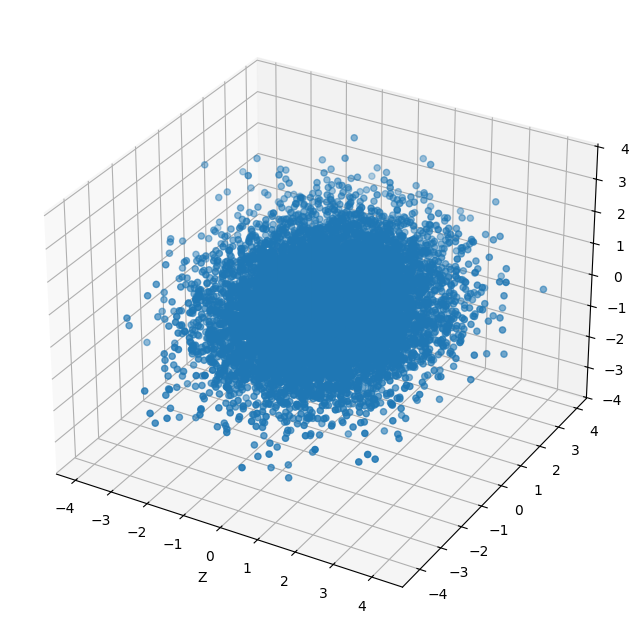

In [4]:
# Run this code to plot your point cloud.
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(points[:,0], points[:,1], points[:,2])

# Plot stuff
ax.set_xlabel('X')
ax.set_xlabel('Y')
ax.set_xlabel('Z')
plt.show()

**Exercise 2.2**: Implement Oja's rule for the generated point cloud.
- Initialize the weight matrix from a standard Gaussian.
- For each point, the target is defined as
$$y=\mathbf{w}^T\mathbf{x}.$$
- For timestep $t$, the global modulator is $$\alpha(t)=1/t,$$ i.e. it decreases over time.
- Don't forget to project the weight vector on the unit sphere after each iteration ($\ell$2-normalization).
- print the final w (you may print intermediary steps)

In [7]:
# TODO
# initialize the weight matrix from the starndat Gaussian
w = torch.randn(3, dtype=torch.float32)

# loop each pointt
for t in range(1, len(points) + 1):
    x = points[t - 1]
    y = torch.dot(w, x) # calculate y
    alpha = 1.0 / t  # calculate alpha

    # oja's update rule
    w = w + alpha * (y * x - (y ** 2) * w)
    w = w / torch.norm(w) # project the sphere

print('the final weights:' , w)


the final weights: tensor([0.6424, 0.7113, 0.2853])


**Exercise 2.3**: Use `torch.linalg.svd()` to compute the principal components of your point cloud. What do you observe?

In [10]:
# TODO
X_centered = points - points.mean(dim=0)

# compute singular vale decomposition
U, S, V = torch.linalg.svd(X_centered)

print(V)
print(U)
print(S)

tensor([[-0.5893, -0.7364, -0.3324],
        [-0.7394,  0.3257,  0.5893],
        [ 0.3256, -0.5930,  0.7364]])
tensor([[-1.5693e-02, -1.0380e-02, -1.0490e-02,  ..., -1.2555e-02,
         -9.0019e-03, -4.2662e-03],
        [-8.2005e-04,  1.5201e-02, -4.0358e-03,  ..., -6.6892e-03,
          1.0859e-02,  1.8034e-03],
        [ 1.0758e-02, -7.7821e-03,  8.1809e-04,  ..., -1.0200e-03,
         -1.0175e-02, -2.8115e-03],
        ...,
        [-1.3098e-02, -5.3635e-03, -1.7488e-03,  ...,  9.9980e-01,
         -4.8591e-05, -4.3355e-05],
        [ 3.3851e-03, -1.6844e-02, -2.7049e-03,  ..., -5.0383e-05,
          9.9970e-01, -8.5077e-05],
        [-1.1227e-03, -5.2096e-03, -9.7722e-04,  ..., -4.3820e-05,
         -8.4802e-05,  9.9997e-01]])
tensor([135.4691, 111.9220,  66.9006])


We can observe that the first row of V consists of the maximum variance.